In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l
import pandas as pd

#### Heatmap

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
	d2l.use_svg_display()
	num_rows, num_cols = matrices.shape[0], matrices.shape[1]
	fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False) # shape0, shape1 -- number of subplots

	for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)): # row_axes seperate out first dimension -- (1, 1, 10, 10) to (1, 10, 10)
		for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)): # ax seperate out second dimension -- (1, 10, 10) to (10, 10)
			pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
			if i == num_rows - 1:
				ax.set_xlabel(xlabel) # we may have (row, col) subplots -- we set xlabel at once at the bottom
			if j == 0:
				ax.set_ylabel(ylabel)
			if titles:
				ax.set_title(titles[j]) # a list a subtitles
	fig.colorbar(pcm, ax=axes, shrink=0.6)

#### Masked sequence

In [3]:
# X: (5, 10)
# value: [1, 5, 3, 6, 2] -- matching the rows 

def sequence_mask(X, valid_len, value=0):
	"""Mask irrelevant entries in sequences."""

	maxlen = X.size(1)
	mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
	#print(mask)

	X[~mask] = value # set the masked elements to value 
	return X

#### Masked softmax operation

In [4]:
# X: (2, 3, 4) -- attention weights
# valid lens: specify how many elements to mask in each minibatch 
# valid lens (high dim): specify how to mask each minibatch 
def masked_softmax(X, valid_lens):
	"""Perform softmax operation by masking elements on the last axis"""

	if valid_lens == None:
		return nn.functional.softmax(X, dim=-1)
	else:
		shape = X.shape
		if valid_lens.dim() == 1:
			# 
			valid_lens = torch.repeat_interleave(valid_lens, shape[1])
		else:
			valid_lens = valid_lens.reshape(-1)
		X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)

		return nn.functional.softmax(X.reshape(shape), dim=-1)

#### Positional encoding

In [5]:
class PositionalEncoding(nn.Module):
	"""Position encoding X+P with dropout"""

	def __init__(self, num_hiddens, dropout, max_len=1000):
		super(PositionalEncoding, self).__init__()
		self.dropout = nn.Dropout(dropout)

		# create a single batch_size 1, long enough P, longer than sequence length
		self.P = torch.zeros((1, max_len, num_hiddens))
		X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
		self.P[:, :, 0::2] = torch.sin(X)
		self.P[:, :, 1::2] = torch.cos(X)

	def forward(self, X):
		X = X + self.P[:, :X.shape[1], :].to(X.device)
		return self.dropout(X)

#### Scaled dot-product attention

In [6]:
class DotProductAttention(nn.Module):
	""""Scaled dot product attention with dropout"""

	def __init__(self, dropout, **kwargs):
		super(DotProductAttention, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)

		# query: (batch_size, no. of queries, 'd')
		# key: (batch_size, no. of key-value pairs, 'd')
		# value: (batch_size, no. of key-value pairs, d_value)
		# valid_lens: (batch_size, ) or (batch_size, no. of queries)
	
	def forward(self, queries, keys, values, valid_lens=None):
		d = queries.shape[-1]

		scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
		self.attention_weights = masked_softmax(scores, valid_lens)
		return torch.bmm(self.dropout(self.attention_weights), values)

#### Multi-head attention

In [7]:
def transpose_qkv(X, num_heads):
	"""Transposition for parallel computation of multiple attention heads"""

	X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
	X = X.permute(0, 2, 1, 3)

	return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
	"""Reverse the operation of transpose_qkv"""

	X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
	X = X.permute(0, 2, 1, 3)

	return X.reshape(X.shape[0], X.shape[1], -1)

In [8]:
# valid_lens: (batch_size, ) or (batch_size, no. of queries)
# Note: the mask (valid_len) used here, I copy it num_heads times

class MultiHeadAttention(nn.Module):
	"""Multi-head attention"""

	def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
		super(MultiHeadAttention, self).__init__(**kwargs)
		self.num_heads = num_heads
		self.attention = DotProductAttention(dropout)
		self.W_q = nn.Linear(query_size, num_hiddens, bias=use_bias) # (in_feature, out_feature)
		self.W_k = nn.Linear(key_size, num_hiddens, bias=use_bias)
		self.W_v = nn.Linear(value_size, num_hiddens, bias=use_bias)
		self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=use_bias)
	
	def forward(self, queries, keys, values, valid_lens):
		
		# queries, keys, values:
		# (batch_size, no. of queries / keys/ values, num_hiddens) ---------------------note here we choose queries_size, value_size, key_size to be num_hiddens
		# valid_lens: (batch_size, ) or (batch_size, no. of queries)

		queries = transpose_qkv(self.W_q(queries), self.num_heads)
		keys = transpose_qkv(self.W_k(keys), self.num_heads)
		values = transpose_qkv(self.W_v(values), self.num_heads)

		if valid_lens is not None:
			valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
		
		print()
		output = self.attention(queries, keys, values, valid_lens)

		output_concat = transpose_output(output, self.num_heads)

		return self.W_o(output_concat)

#### Positionwise Feed-Forward Networks

In [9]:
class PositionWiseFFN(nn.Module):
	"""Positionwise feed-forward network"""

	def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
		super(PositionWiseFFN, self).__init__(**kwargs)
		self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
		self.relu = nn.ReLU()
		self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

	def forward(self, X):
		return self.dense2(self.relu(self.dense1(X)))

#### Residual connection and layer normalization

In [10]:
# input: (batch_size, seq_length, features_dim)
# normalized shape is input.size()[1: ]
# the normalizing direction is features_dim -- nomalizing along second dimension

# X is input 
# Y is Multiattention(X)

class AddNorm(nn.Module):
	"""Residual connection followed by layer normalization with dropout implementation"""

	def __init__(self, normalized_shape, dropout, **kwargs):
		super(AddNorm, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)
		self.ln = nn.LayerNorm(normalized_shape)

	def forward(self, X, Y): 
		return self.ln(self.dropout(Y) + X)

#### Encoder

In [11]:
class EncoderBlock(nn.Module):
	"""Transformer encoder block."""

	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
		super(EncoderBlock, self).__init__(**kwargs)
		self.attention = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout, use_bias=use_bias)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm2 = AddNorm(norm_shape, dropout)

	def forward(self, X, valid_lens):
		Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
		return self.addnorm2(Y, self.ffn(Y))

#### Transformer encoder

In [12]:
# we can now stack the blocks of encoders
# we also need to rescale to learnable input embeddings by sqrt(embedding dim) to [-1, 1]. This is because each value of positional embeddding is [-1, 1]
# num_layers: number of blocks of encoder
# vocab_size: size of vocabulary dictionary

class TransformerEncoder(d2l.Encoder):
	"""Transformer encoder."""

	def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
		super(TransformerEncoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.embedding = nn.Embedding(vocab_size, num_hiddens) # here we randomly initialize a input embedding matrix 
		self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("Block"+str(i), EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=use_bias))
	
	def forward(self, X, valid_lens, *args):
		
		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self.attention_weights = [None] * len(self.blks) # create a attention weight list to hold attention weights at each block
		for i, blk in enumerate(self.blks):
			X = blk(X, valid_lens)
			self.attention_weights[i] = blk.attention.attention.attention_weights # the actual attention weights is stored in the ScaledDotAttention
		
		return X

#### Decoder

In [13]:
# self.i stores all previous representations

class DecoderBlock(nn.Module):
	"""The ith decoder block"""
	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
		super(DecoderBlock, self).__init__(**kwargs)
		self.i = i
		self.attention1 = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.attention2 = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm2 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm3 = AddNorm(norm_shape, dropout)

	def forward(self, X, state):
		# state: (encoder_output, encoder_valid_len, some info)
		enc_outputs, enc_valid_lens = state[0], state[1]

		if state[2][self.i] is None: # if nothing is stored previously, we use all X. This only occurs during training
			key_values = X
		else:
			key_values = torch.cat((state[2][self.i], X), axis=1) # we combine the previous with current X. This often occurs during prediction ------------------- ?potential issues
		state[2][self.i] = key_values

		if self.training: # True if training procedure applied
			batch_size, num_steps, _ = X.shape # (batch_size, previous_timesteps, hidden_dimension)
			dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1) # repeat to size (2, 1), this specifies how we mask each row in each minibatch
		else:
			dec_valid_lens = None # for prediction, we do not need mask, since we do not know what is after
		
		# main model
		# q, k, v as defined
		X2 = self.attention1(X, key_values, key_values, dec_valid_lens) # training: all X, but we mask all after, prediction: queries=current timestep repr, keys_values, all previous 
		Y = self.addnorm1(X, X2)
		Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # in the case encoder is masked 
		Z = self.addnorm2(Y, Y2)

		return self.addnorm3(Z, self.ffn(Z)), state # state here is passed as it was 

	# some additional notes: 
	# decoder consists of 2 functionality: training and prediction 

	# during training: we use the whole sequence but mask attention weights
	# The attention weights matrix has dimension (q, k) -- the second query will only get acess to the first 2 key
	# state[2] is [None]

	# during prediction: we only have current embedding -- 1 query 
	# the key-values combine current and all previous key-valuee to search for -- decoder self attention 

#### Transformer Decoder

In [14]:
class TransformerDecoder(d2l.AttentionDecoder):

	def __init__(self, vocab_size,  key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
		super(TransformerDecoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.num_layers = num_layers
		self.embedding = nn.Embedding(vocab_size, num_hiddens)
		self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("block"+str(i), DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
		self.dense = nn.Linear(num_hiddens, vocab_size)
		# prediction: we have (1, num_hiddens) --> (1, num_vocab_size)

	def init_state(self, enc_outputs, enc_valid_lens, *args):
		return [enc_outputs, enc_valid_lens, [None]*self.num_layers]

	def forward(self, X, state):
		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self._attention_weights = [[None] * len(self.blks) for _ in range(2)] # here we record attention from 2 attention module (2, i)
		for i, blk in enumerate(self.blks):

			X, state = blk(X, state)
			# Decoder self-attention weights
			self._attention_weights[0][i] = blk.attention1.attention.attention_weights
			# Encoder-decoder attention weights
			self._attention_weights[1][i] = blk.attention2.attention.attention_weights
		
		return self.dense(X), state

	def attention_weights(self):
		return self._attention_weights

#### Encoder to Decoder architecture

In [15]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)  # feature representation from encoder
        dec_state = self.decoder.init_state(enc_outputs, *args) # use the feature representation from encoder to process a decoder init: (training--None), (prediction -- previous important information)
        return self.decoder(dec_X, dec_state)

#### The softmax cross-entropy loss with mask

In [16]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
	"""The softmax cross-entropy loss with masks."""
	# 'pred' shape: ('batch_size', 'num_steps', 'vocab_size')  ---> shape should be (0, 2, 1)
	# 'label' shape: ('batch_size', num_steps) --- each number is a number between 0 and vocab_size/prob
	# 'valid_len' shape: ('batch_size', )

	# "none" return same shape as 'label'
	
	# num_steps have to be the same 
	# during training, our labeled/pred length can be very long. We can restrict the length of each batch.
	# we ignore the irrelevant part
	def forward(self, pred, label, valid_len):
		weights = torch.ones_like(label)
		weights = sequence_mask(weights, valid_len)
		self.reduction = 'none'
		unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
		weighted_loss = (unweighted_loss * weights).mean(dim=1) # mean of each batch along num_steps
		return weighted_loss

#### Transformer training

In [17]:
# Here we enforce the first word <bos>

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing -------> the first word at all batch is <bos>
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

#### Transformer prediction

In [18]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)


    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):

        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights())
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## Task 1: small languague dataset

#### Initialize parameter

In [19]:
# initialize parameters of model

num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32] # 32 corresponds to the dim of such number to normalize  

#### Inspection of dataset

In [20]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [21]:
for batch in train_iter:
	print(batch[2])

tensor([[ 92,  70,  32,   3,   5,   6,   6,   6,   6,   6],
        [ 96, 165,   7,   1,   5,   6,   6,   6,   6,   6],
        [  7,   1,   5,   6,   6,   6,   6,   6,   6,   6],
        [ 96, 165,   7,   1,   5,   6,   6,   6,   6,   6],
        [114,   1,   5,   6,   6,   6,   6,   6,   6,   6],
        [ 96, 186,  66,   7,   3,   5,   6,   6,   6,   6],
        [144,   9,  84,   8,   5,   6,   6,   6,   6,   6],
        [173,   7,   3,   5,   6,   6,   6,   6,   6,   6],
        [  7,   3,   5,   6,   6,   6,   6,   6,   6,   6],
        [ 94, 133,   3,   5,   6,   6,   6,   6,   6,   6],
        [  7,   8,   5,   6,   6,   6,   6,   6,   6,   6],
        [  7,   3,   5,   6,   6,   6,   6,   6,   6,   6],
        [ 94, 101,   7,   7,   3,   5,   6,   6,   6,   6],
        [194, 135, 168,   1,   5,   6,   6,   6,   6,   6],
        [156,   1,   5,   6,   6,   6,   6,   6,   6,   6],
        [ 96, 165,  53, 101, 129,   3,   5,   6,   6,   6],
        [ 90,  53, 143,   1,   5,   6,  

In [22]:
dir(tgt_vocab)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'idx_to_token',
 'to_tokens',
 'token_freqs',
 'token_to_idx',
 'unk']

In [23]:
dir(src_vocab)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'idx_to_token',
 'to_tokens',
 'token_freqs',
 'token_to_idx',
 'unk']

In [24]:
tgt_vocab.token_to_idx

{'': 0,
 '!': 1,
 ',': 2,
 '.': 3,
 '<bos>': 4,
 '<eos>': 5,
 '<pad>': 6,
 '<unk>': 7,
 '?': 8,
 'a': 9,
 'aboient': 10,
 'ai': 11,
 'aide': 12,
 'aide-moi': 13,
 'aller': 14,
 'allez': 15,
 'allons-y': 16,
 'appelle': 17,
 'asseyez-vous': 18,
 'assieds-toi': 19,
 'attendez': 20,
 'attends': 21,
 'attrape': 22,
 'attrapez': 23,
 'au': 24,
 'aucune': 25,
 'avons': 26,
 'battues': 27,
 'battus': 28,
 'bien': 29,
 'bientã´t': 30,
 'bizarre': 31,
 'bon': 32,
 'bonne': 33,
 'boulot': 34,
 'bras': 35,
 "c'est": 36,
 'calme': 37,
 'calmes': 38,
 'calmez-vous': 39,
 'ceci': 40,
 'certain': 41,
 'chercher': 42,
 'chez': 43,
 'chiens': 44,
 'comme': 45,
 'comment': 46,
 'compris': 47,
 'confiance': 48,
 'continuez': 49,
 'cours': 50,
 'court': 51,
 'dans': 52,
 'de': 53,
 'debout': 54,
 'demande': 55,
 'doucement': 56,
 'du': 57,
 'dã©faites': 58,
 'dã©faits': 59,
 'dã©gageâ€¯': 60,
 'dã©tendu': 61,
 'elle': 62,
 'elles': 63,
 'emploi': 64,
 'emportã©': 65,
 'en': 66,
 'entre': 67,
 'entrezâ€¯':

In [25]:
src_vocab.token_to_idx

{'!': 0,
 ',': 1,
 '.': 2,
 '<bos>': 3,
 '<eos>': 4,
 '<pad>': 5,
 '<unk>': 6,
 '?': 7,
 'a': 8,
 'agree': 9,
 'ahead': 10,
 'am': 11,
 'ask': 12,
 'attack': 13,
 'away': 14,
 'back': 15,
 'bark': 16,
 'be': 17,
 'beats': 18,
 'bed': 19,
 'beg': 20,
 'busy': 21,
 'call': 22,
 'calm': 23,
 'came': 24,
 'can': 25,
 'catch': 26,
 'cheers': 27,
 'cold': 28,
 'come': 29,
 'cool': 30,
 'cringed': 31,
 'deaf': 32,
 'did': 33,
 'die': 34,
 'died': 35,
 'dogs': 36,
 "don't": 37,
 'down': 38,
 'dozed': 39,
 'drive': 40,
 'drop': 41,
 'excuse': 42,
 'fair': 43,
 'fat': 44,
 'feel': 45,
 'fell': 46,
 'find': 47,
 'fine': 48,
 'fire': 49,
 'fix': 50,
 'follow': 51,
 'for': 52,
 'forget': 53,
 'free': 54,
 'full': 55,
 'fun': 56,
 'game': 57,
 'get': 58,
 'go': 59,
 'good': 60,
 'got': 61,
 'grab': 62,
 'hang': 63,
 'have': 64,
 'he': 65,
 "he's": 66,
 'hello': 67,
 'help': 68,
 'here': 69,
 'hi': 70,
 'him': 71,
 'his': 72,
 'hit': 73,
 'hold': 74,
 'home': 75,
 'hop': 76,
 'how': 77,
 "how's": 78,

In [26]:
print(len(train_iter))
print(len(src_vocab))
print(len(tgt_vocab))

10
184
195


#### Model training

loss 0.030, 3493.6 tokens/sec on cpu


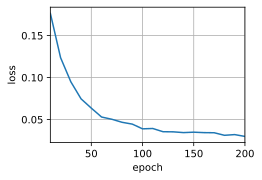

In [27]:
encoder = TransformerEncoder(
	len(src_vocab), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder = TransformerDecoder(
	len(tgt_vocab), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

#### Model prediction

In [28]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ', f'bleu {d2l.bleu(translation, fra, k=2):.3f}')















go . => va !,  bleu 1.000


















i lost . => j'ai perdu .,  bleu 1.000






















he's calm . => il est mouillã© .,  bleu 0.658


























i'm home . => je suis chez moi .,  bleu 1.000


## Task 2: Generative ability test on protein dataset

In [29]:
import pickle

#### Initialize parameters

In [30]:
# initialize parameters of model

num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 1, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32] # 32 corresponds to the dim of such number to normalize  

#### Inspection of dataset

In [31]:
import os

os.getcwd()

'c:\\Users\\10331\\Haowen_academic_in_use\\UROP\\Transformer_based_model'

In [32]:
data_list_antiparallel= []
data_list_parallel= []

for i in range(1, 9):
	with open('BSn_libraries/BSn_libraries_copy/anti_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_antiparallel.append(data)

	with open('BSn_libraries/BSn_libraries_copy/para_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_parallel.append(data)

WARNING mybio.py module not found - excecution may fail
WARNING zyggregator not found!!!


Working score: $C = \sum_{i=1}^{n} (l_i^2c_i - 0.01l_ip_i)$

In [45]:
# 0 for parallel
# 1 for antiparallel

# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti
BSn_data = []
least_length = 3

for frag_i_data in data_list_parallel[least_length-1:]:
	for keys in frag_i_data.keys():

		length = len(keys)
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 0]
			BSn_data.append(list_i)

for frag_i_data in data_list_antiparallel[least_length-1:]:
	for keys in frag_i_data.keys():
		length = len(keys)
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 1]
			BSn_data.append(list_i)

In [46]:
len(BSn_data)

2206533

In [56]:
BSn_data[500000]

['VAA', 'IVV', 1, 606, 3, -9.18, ((0, 0), (None, None), (0, 0)), 1]

#### Tailor the dataset

In [64]:
amino_list1=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [63]:
amino_dict = {
		'<bos>': 1, 
		'<eos>': 2, 
		'<pad>': 3, 
		'<unk>': 4,
		'A': 5,
		'C': 6,
		'D': 7, 
		'E': 8,
		'F': 9, 
		'G': 10, 
		'H': 11,
		'I': 12, 
		'K': 13, 
		'L': 14, 
		'M': 15, 
		'N': 16, 
		'P': 17, 
		'Q': 18, 
		'R': 19, 
		'S': 20, 
		'T': 21, 
		'V': 22, 
		'W': 23, 
		'Y': 24 
		 }

In [60]:
import numpy as np

In [61]:
BSn_data_dataset1 = np.array(BSn_data)[:, 0:2]

C:\Users\10331\AppData\Local\Temp\ipykernel_12864\910978762.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  BSn_data_dataset1 = np.array(BSn_data)[:, 0:2]


In [62]:
BSn_data_dataset1

array([['SPY', 'WHA'],
       ['SPY', 'LVL'],
       ['SPQ', 'GFD'],
       ...,
       ['SFILKSFR', 'EAQVWIAM'],
       ['LDLRNFYQ', 'LTYNVIFR'],
       ['LDLRNFYQ', 'LVFGQSWN']], dtype=object)